In [66]:
import matplotlib.pyplot as plt 
import pandas as pd   
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2
from collections import Counter
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

## Importing dataset & Checking for missing data

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0            7.4              0.70         0.00             1.9      0.076  \
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates   
0                 11.0                  34.0   0.9978  3.51       0

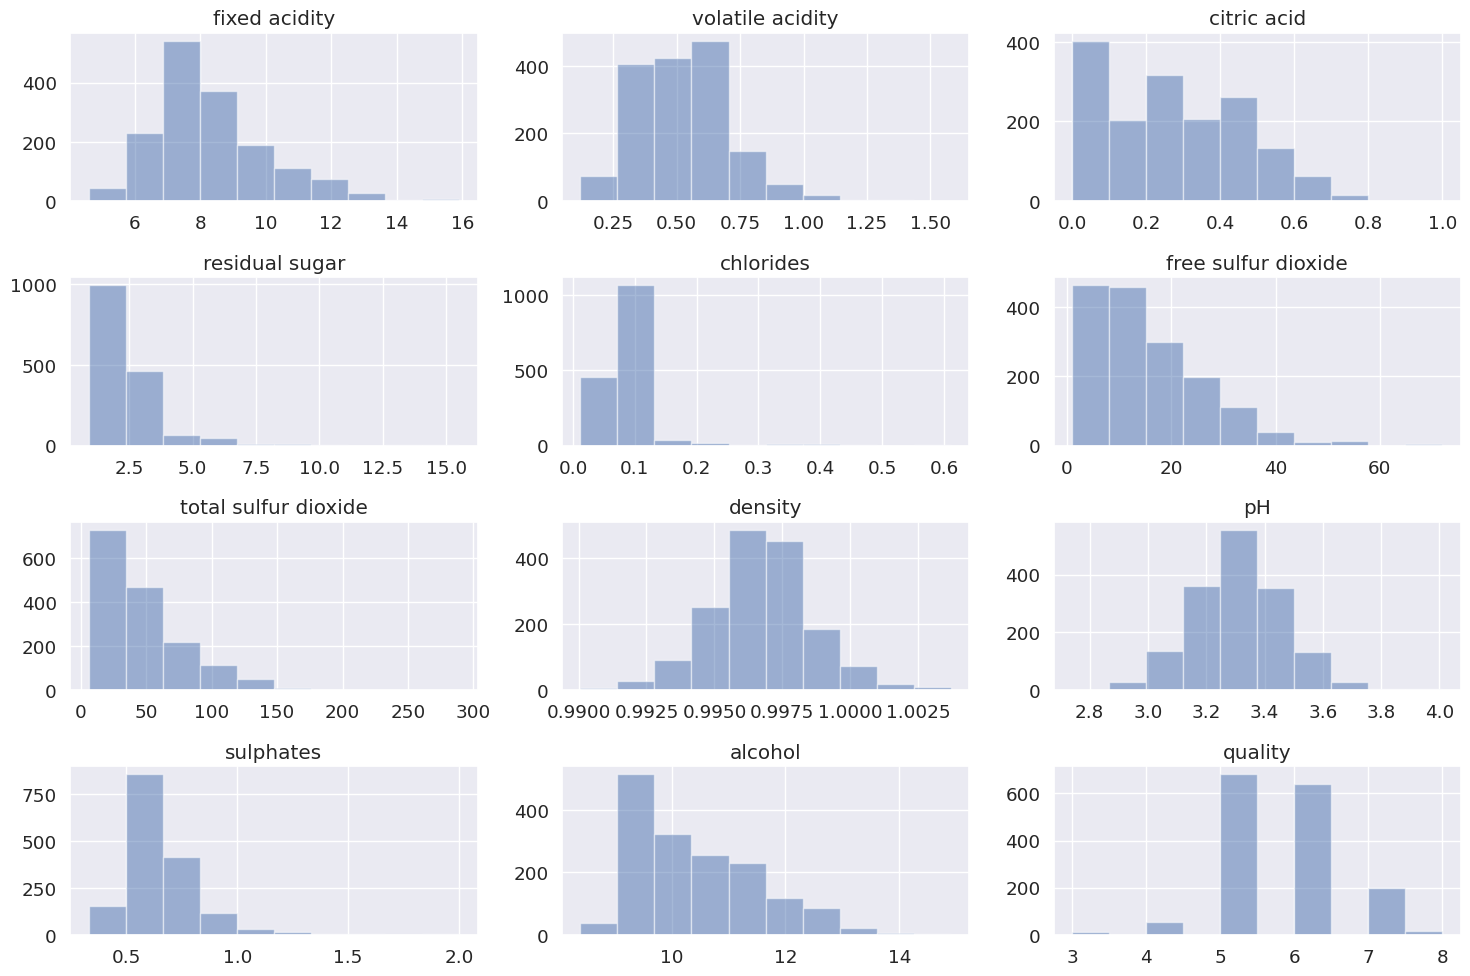


Checking for null values: 


Checking for null values after using fillna(): 



fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [67]:
headerList = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

wineData = pd.read_csv('winequality-red.csv', header = 0, names = headerList, sep=";")
print(wineData.head(10))
print(wineData)

#Summarative functions
wineData.dtypes
wineData.describe()
wineData.info()

#Plotting histogram of each variable
wineData.hist(alpha=0.5, figsize=(15, 10))
plt.tight_layout()
plt.show()

for h in headerList:
  wineData[h] = pd.to_numeric(wineData[h], errors='coerce')

print("\nChecking for null values: \n")
wineData.isna().sum()
wineData = wineData.fillna(0)
print("\nChecking for null values after using fillna(): \n")
wineData.isna().sum()


### Our data is imbalanced as seen from the histogram. We will adapt multiple strategies to address the issue.

# 2. Exploratory Data Analysis

## 1. Principal Component Analysis (PCA)

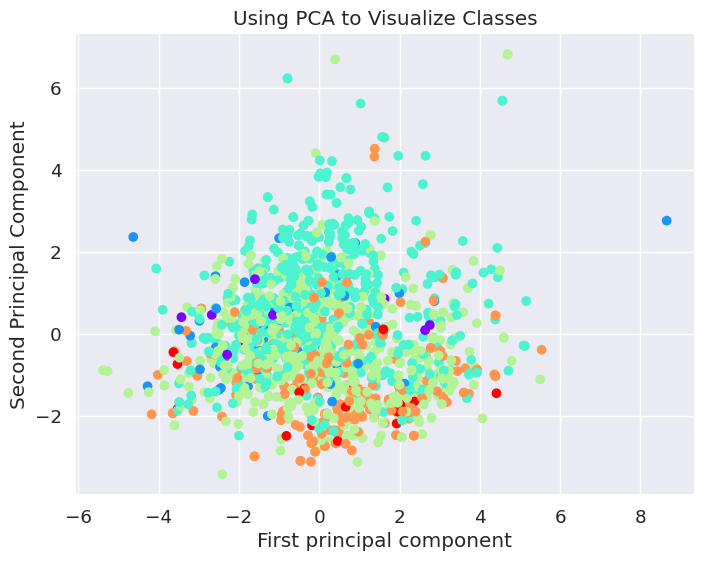

components:  [[ 0.48931422 -0.23858436  0.46363166  0.14610715  0.21224658 -0.03615752
   0.02357485  0.39535301 -0.43851962  0.24292133 -0.11323206]
 [-0.11050274  0.27493048 -0.15179136  0.27208024  0.14805156  0.51356681
   0.56948696  0.23357549  0.00671079 -0.03755392 -0.38618096]] 

explained variance:  [3.10107182 1.92711489] 

explained variance ratio:  [0.28173931 0.1750827 ]


In [68]:
#PCA
df_pca = wineData.copy()
X_pca = df_pca.loc[:, 'fixed acidity':'alcohol']
y_pca = df_pca['quality']

X_pca.tail()
X_pca = StandardScaler().fit_transform(X_pca)

#Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

X_pca.shape

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_pca,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title("Using PCA to Visualize Classes")
plt.show()

print("components: ", pca.components_, "\n")
print("explained variance: ", pca.explained_variance_, "\n")
exp_var_rat = pca.explained_variance_ratio_
print("explained variance ratio: ", exp_var_rat)

## 2. Correlation Matrix

<Axes: >

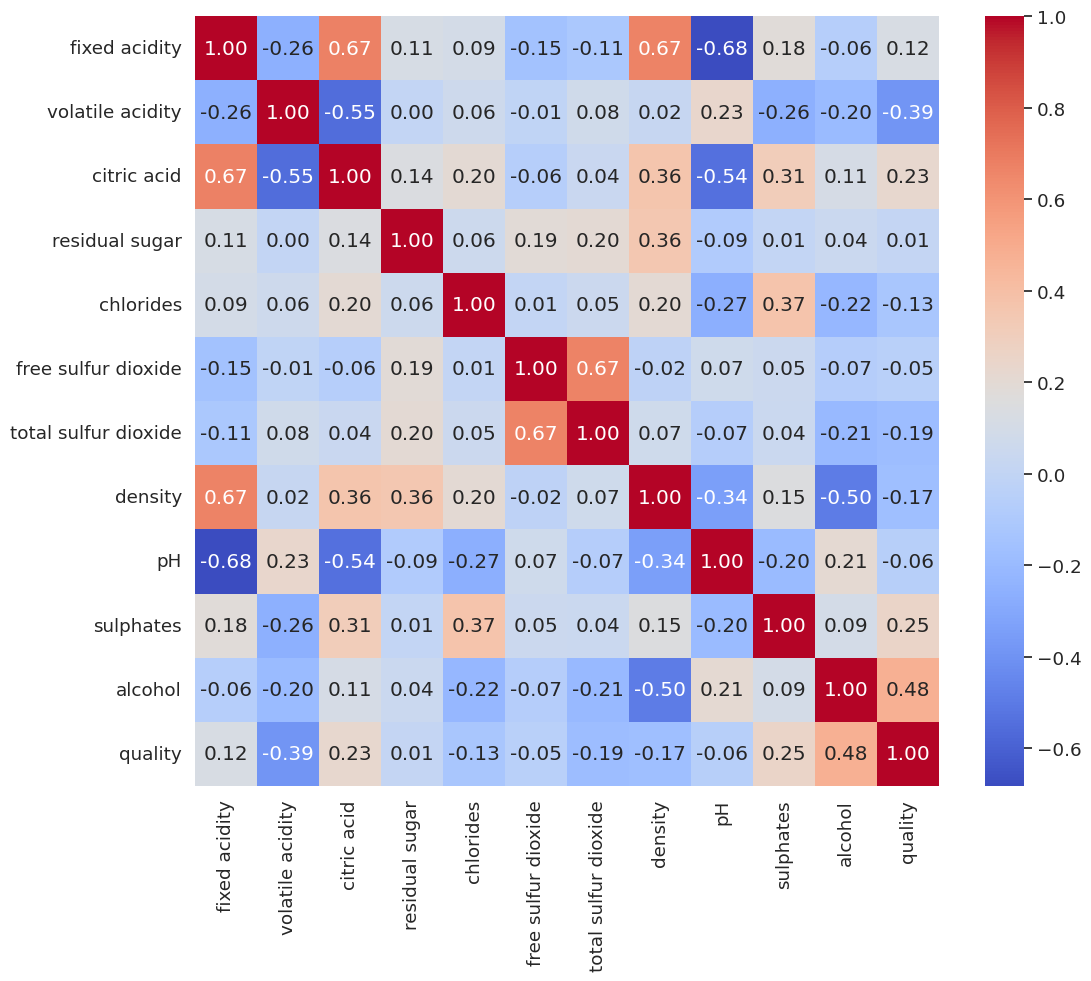

In [69]:
plt.figure(figsize=(12,10))
sns.heatmap(wineData.corr(),annot=True, cmap='coolwarm',fmt='.2f')

## 3. Univariate Selection

In [70]:
#Split data into training and test sets
X = wineData.loc[:, 'fixed acidity':'alcohol']
y = wineData['quality']

# apply SelectKBest class to extract best features
bestFeatures = SelectKBest(score_func=chi2, k=11)
bestFeaturesFit = bestFeatures.fit(X,y)
dfscores = pd.DataFrame(bestFeaturesFit.scores_)
dfcolumns = pd.DataFrame(X.columns) 

# concatenate scores with predictor names
predScores = pd.concat([dfcolumns,dfscores],axis=1)
predScores.columns = ['Predictor','Score']
print(predScores.nlargest(11,'Score'))   

               Predictor        Score
6   total sulfur dioxide  2755.557984
5    free sulfur dioxide   161.936036
10               alcohol    46.429892
1       volatile acidity    15.580289
2            citric acid    13.025665
0          fixed acidity    11.260652
9              sulphates     4.558488
3         residual sugar     4.123295
4              chlorides     0.752426
8                     pH     0.154655
7                density     0.000230


## Dropping features from univariate selection

### We are dropping bottom features as they have very low predictor scores and to save computation

In [71]:
#Drop the bottom four features (smallest score)
wineData = wineData.drop(['density'], axis=1)
wineData = wineData.drop(['pH'], axis=1)
wineData = wineData.drop(['chlorides'], axis=1)
print(wineData)

X = wineData.loc[:, 'fixed acidity':'alcohol']
y = wineData['quality']

      fixed acidity  volatile acidity  citric acid  residual sugar   
0               7.4             0.700         0.00             1.9  \
1               7.8             0.880         0.00             2.6   
2               7.8             0.760         0.04             2.3   
3              11.2             0.280         0.56             1.9   
4               7.4             0.700         0.00             1.9   
...             ...               ...          ...             ...   
1594            6.2             0.600         0.08             2.0   
1595            5.9             0.550         0.10             2.2   
1596            6.3             0.510         0.13             2.3   
1597            5.9             0.645         0.12             2.0   
1598            6.0             0.310         0.47             3.6   

      free sulfur dioxide  total sulfur dioxide  sulphates  alcohol  quality  
0                    11.0                  34.0       0.56      9.4        5  
1

# Addressing Imbalance in Class

## First Strategy: Oversampling minority class

In [72]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
print("Before RandomOverSampler : ", Counter(y))
print("After RandomOverSampler : ", Counter(y_over))

Before RandomOverSampler :  Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
After RandomOverSampler :  Counter({5: 681, 3: 681, 6: 638, 7: 199, 4: 53, 8: 18})


## Second Strategy: Undersampling majority class

In [73]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
print("Before RandomUnderSampler : ", Counter(y))
print("After RandomUnderSampler : ", Counter(y_under))

Before RandomUnderSampler :  Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
After RandomUnderSampler :  Counter({6: 638, 7: 199, 4: 53, 8: 18, 3: 10, 5: 10})


## Third Strategy: SMOTE

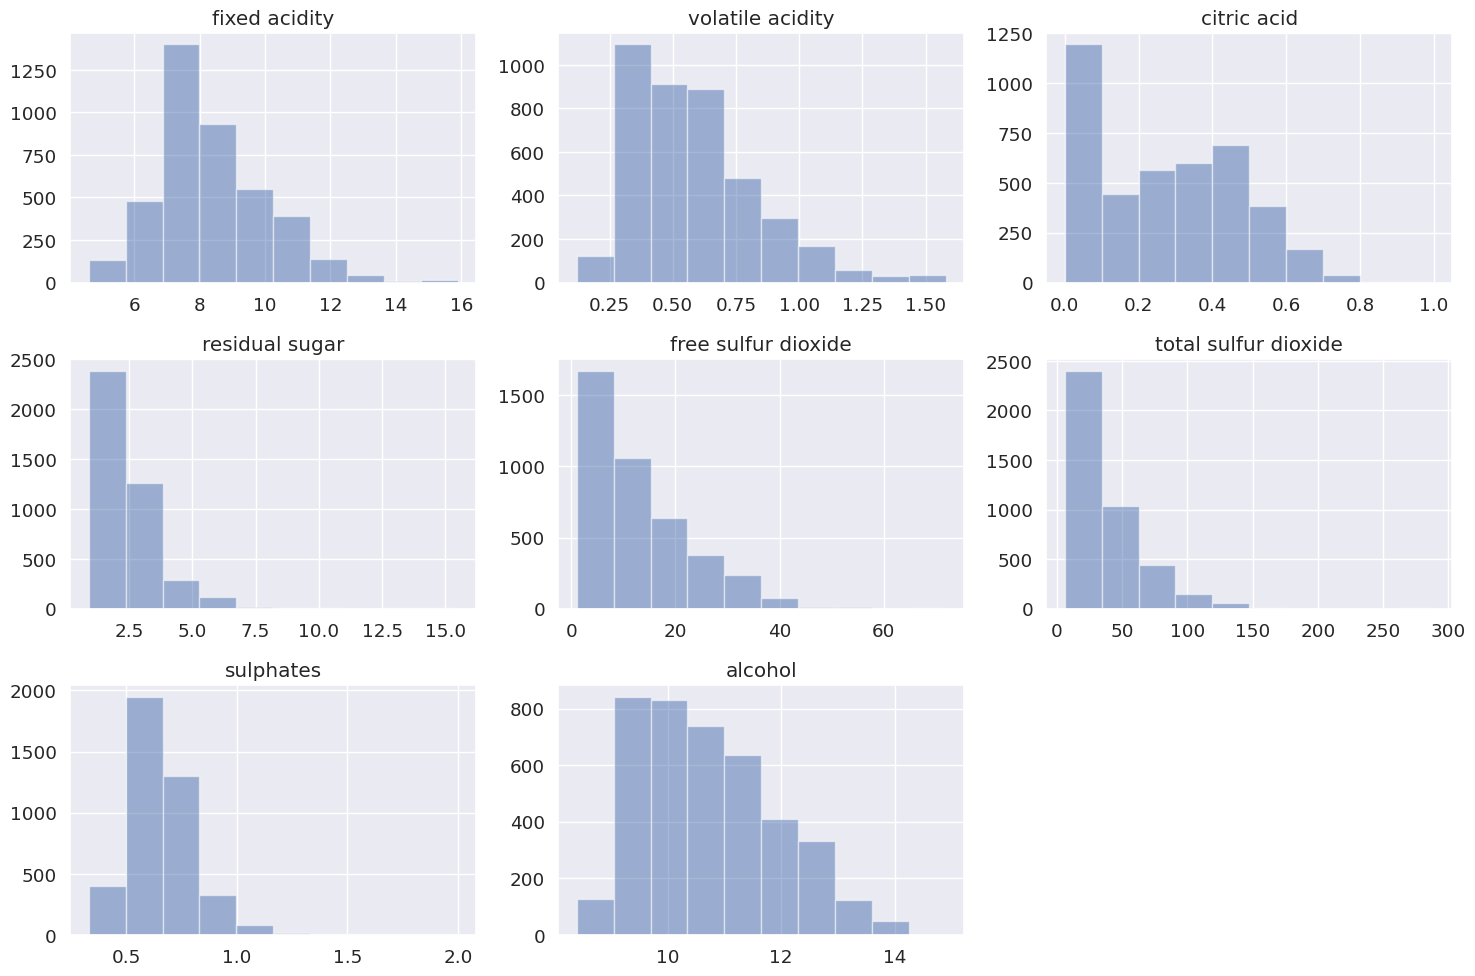

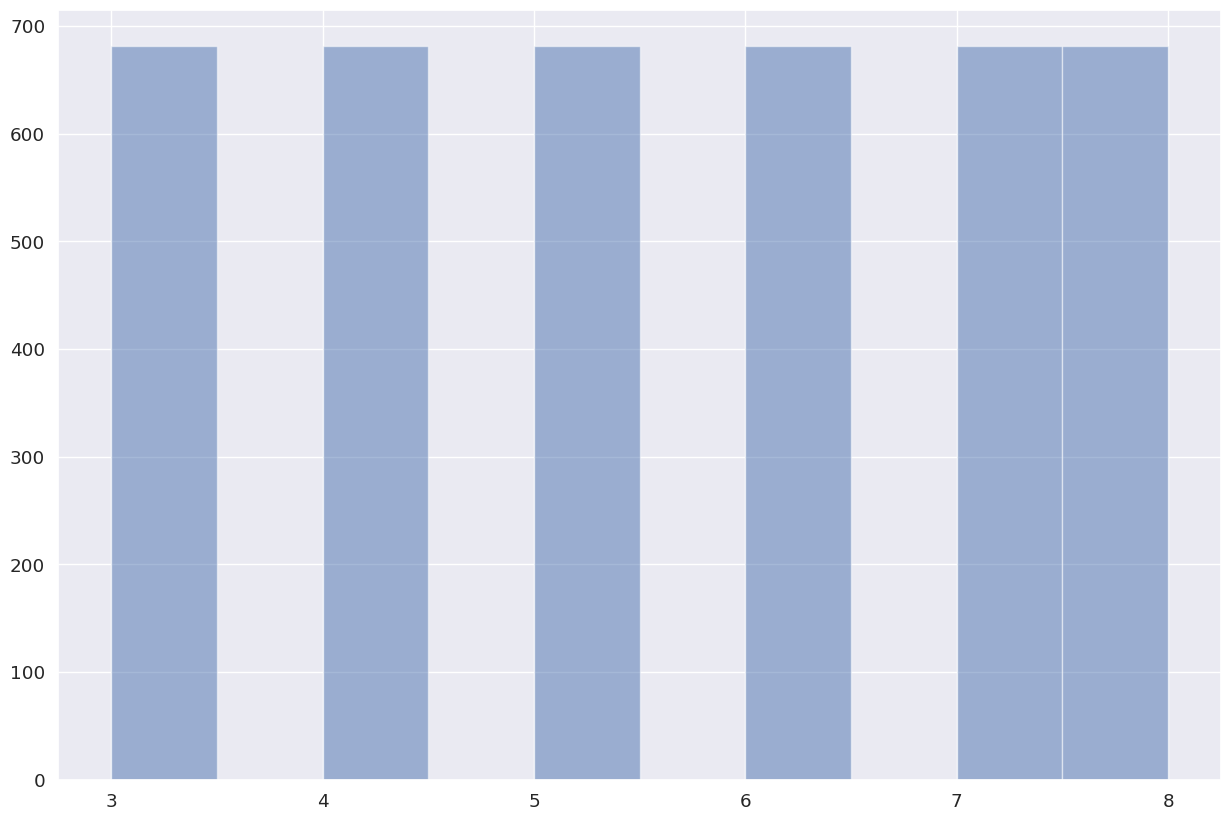

Before SMOTE :  Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
After SMOTE :  Counter({5: 681, 6: 681, 7: 681, 4: 681, 8: 681, 3: 681})


In [74]:
smoteOversample = SMOTE()
X_smote, y_smote = smoteOversample.fit_resample(X, y)

#Plotting histogram of each variable
X_smote.hist(alpha=0.5, figsize=(15, 10))

plt.tight_layout()
plt.show()

y_smote.hist(alpha=0.5, figsize=(15, 10))
plt.show()

from collections import Counter
print("Before SMOTE : ", Counter(y))
print("After SMOTE : ", Counter(y_smote))

## Fourth Strategy: Data Imputation
### Filling in data from missing classes - 0, 1, 2, 9, & 10 with fraud data

In [75]:
avgX = X.mean(axis=0)
dfImpute = pd.DataFrame(
                        [[avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 0], 
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 1],
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 2],
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 9],
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 10]],
                        columns=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol', 'quality']
                        )
dfImpute

,fixed acidity,volatile acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,8.319637,0.527821,0.270976,2.538806,15.874922,46.467792,0.658149,10.422983,0
1,8.319637,0.527821,0.270976,2.538806,15.874922,46.467792,0.658149,10.422983,1
2,8.319637,0.527821,0.270976,2.538806,15.874922,46.467792,0.658149,10.422983,2
3,8.319637,0.527821,0.270976,2.538806,15.874922,46.467792,0.658149,10.422983,9
4,8.319637,0.527821,0.270976,2.538806,15.874922,46.467792,0.658149,10.422983,10


# 3. Comparing Machine Learning Models / Obtaining Baseline Accuracy

## Modeling - Final data preparations

In [76]:
# 1. Regular Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=10) #split the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape
scaledData = StandardScaler()
X_train = scaledData.fit_transform(X_train)
X_test = scaledData.transform(X_test)

# 2. Oversampled Data
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size = .2, random_state=10) #split the data
X_over_train.shape, y_over_train.shape, X_over_test.shape, y_over_test.shape
X_over_train = scaledData.fit_transform(X_over_train)
X_over_test = scaledData.transform(X_over_test)

# 3. Underrsampled Data
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size = .2, random_state=10) #split the data
X_under_train.shape, y_under_train.shape, X_under_test.shape, y_under_test.shape
X_under_train = scaledData.fit_transform(X_under_train)
X_under_test = scaledData.transform(X_under_test)

#4. SMOTE Data
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size = .2, random_state=10) #split the data
X_smote_train.shape, y_smote_train.shape, X_smote_test.shape, y_smote_test.shape
X_smote_train = scaledData.fit_transform(X_smote_train)
X_smote_test = scaledData.transform(X_smote_test)

# 5. Imputed Data
X_impute = wineData.loc[:, 'fixed acidity':'alcohol']
y_impute = wineData['quality']
X_add = dfImpute.loc[:, 'fixed acidity':'alcohol']
y_add = dfImpute['quality']
X_impute_train, X_impute_test, y_impute_train, y_impute_test = train_test_split(X_impute, y_impute, test_size = .2, random_state=10) #split the data
X_impute_train = pd.concat([X_impute_train, X_add])
X_impute_test = pd.concat([X_impute_test, X_add])
y_impute_train = pd.concat([y_impute_train, y_add])
y_impute_test = pd.concat([y_impute_test, y_add])
X_impute_train.shape, y_impute_train.shape, X_impute_test.shape, y_impute_test.shape
X_impute_train = scaledData.fit_transform(X_impute_train)

In [77]:
def clas_report(X_train, y_train, x_test, y_test, model, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    sns.set(font_scale=1.2) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()
    clas = classification_report(y_test, y_pred)
    print(title, "\n",clas)

## 1. Random Forest Classifier

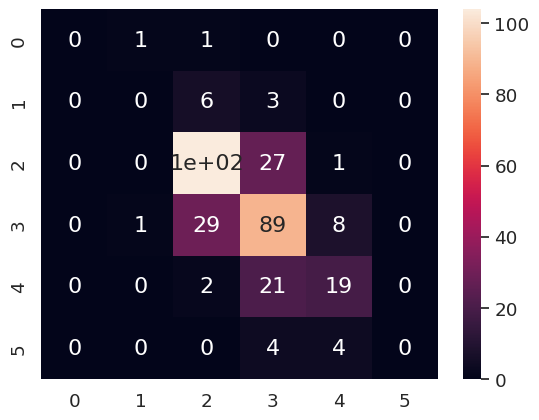

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.73      0.79      0.76       132
           6       0.62      0.70      0.66       127
           7       0.59      0.45      0.51        42
           8       0.00      0.00      0.00         8

    accuracy                           0.66       320
   macro avg       0.32      0.32      0.32       320
weighted avg       0.63      0.66      0.64       320



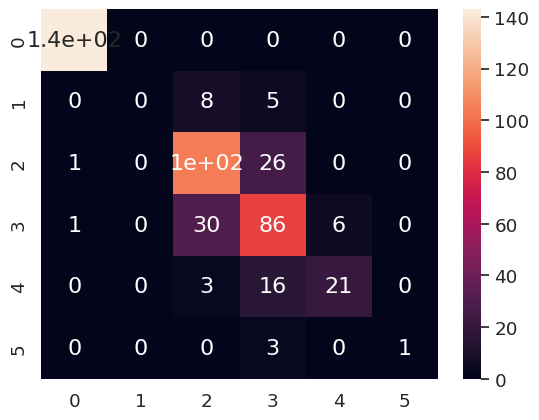

Oversampled Data 
               precision    recall  f1-score   support

           3       0.99      1.00      0.99       143
           4       0.00      0.00      0.00        13
           5       0.72      0.79      0.75       131
           6       0.63      0.70      0.66       123
           7       0.78      0.53      0.63        40
           8       1.00      0.25      0.40         4

    accuracy                           0.78       454
   macro avg       0.69      0.54      0.57       454
weighted avg       0.77      0.78      0.77       454



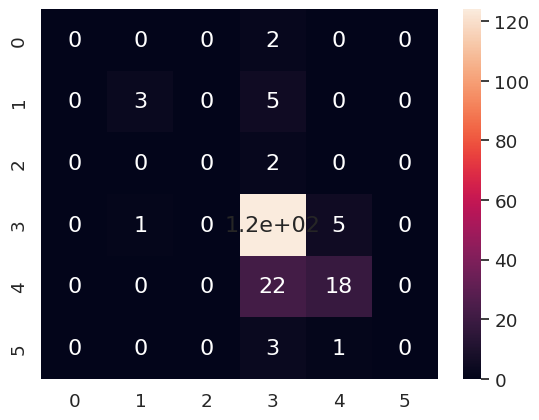

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.75      0.38      0.50         8
           5       0.00      0.00      0.00         2
           6       0.78      0.95      0.86       130
           7       0.75      0.45      0.56        40
           8       0.00      0.00      0.00         4

    accuracy                           0.78       186
   macro avg       0.38      0.30      0.32       186
weighted avg       0.74      0.78      0.74       186



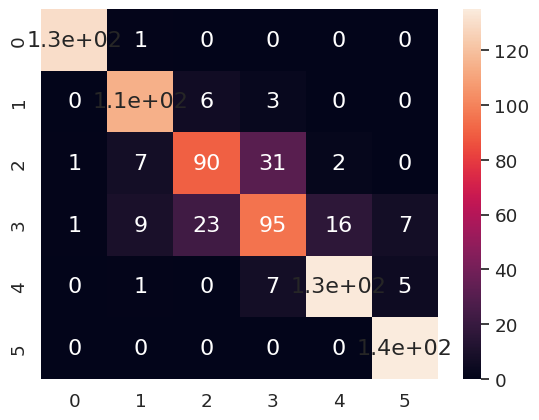

SMOTE Data 
               precision    recall  f1-score   support

           3       0.98      0.99      0.99       131
           4       0.86      0.93      0.89       123
           5       0.76      0.69      0.72       131
           6       0.70      0.63      0.66       151
           7       0.88      0.91      0.90       147
           8       0.92      1.00      0.96       135

    accuracy                           0.85       818
   macro avg       0.85      0.86      0.85       818
weighted avg       0.85      0.85      0.85       818



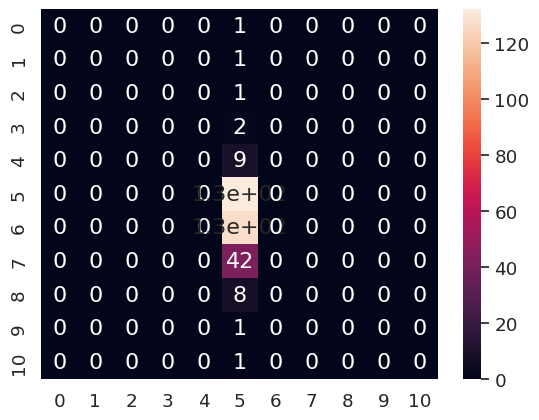

Imputed Data 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.41      1.00      0.58       132
           6       0.00      0.00      0.00       127
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.41       325
   macro avg       0.04      0.09      0.05       325
weighted avg       0.16      0.41      0.23       325



In [78]:
wineRF = RandomForestClassifier()
clas_report(X_train, y_train, X_test, y_test, wineRF, 'Regular Data')
clas_report(X_over_train, y_over_train, X_over_test, y_over_test, wineRF, 'Oversampled Data')
clas_report(X_under_train, y_under_train, X_under_test, y_under_test, wineRF, 'Undersampled Data')
clas_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineRF, 'SMOTE Data')
clas_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineRF, 'Imputed Data')

## 2. Support Vector Machine

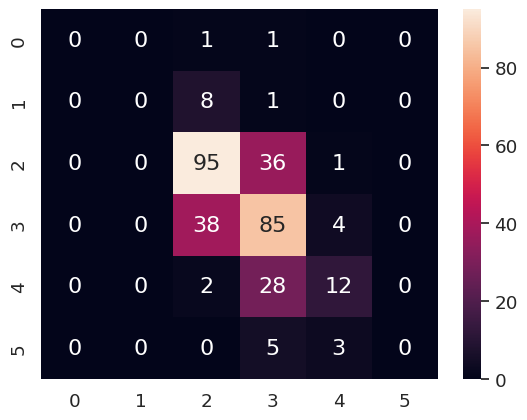

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.66      0.72      0.69       132
           6       0.54      0.67      0.60       127
           7       0.60      0.29      0.39        42
           8       0.00      0.00      0.00         8

    accuracy                           0.60       320
   macro avg       0.30      0.28      0.28       320
weighted avg       0.57      0.60      0.57       320



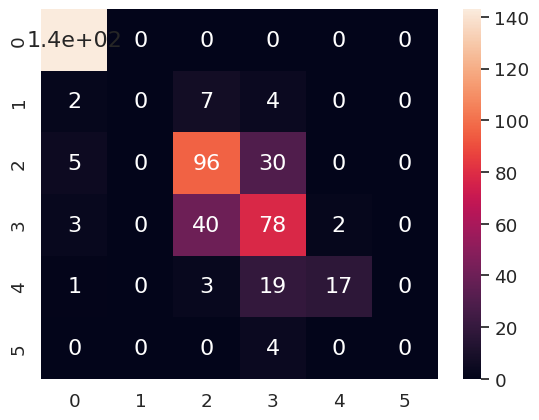

Oversampled Data 
               precision    recall  f1-score   support

           3       0.93      1.00      0.96       143
           4       0.00      0.00      0.00        13
           5       0.66      0.73      0.69       131
           6       0.58      0.63      0.60       123
           7       0.89      0.42      0.58        40
           8       0.00      0.00      0.00         4

    accuracy                           0.74       454
   macro avg       0.51      0.47      0.47       454
weighted avg       0.72      0.74      0.72       454



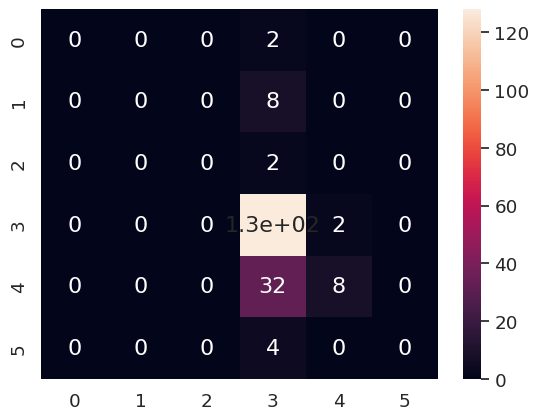

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         2
           6       0.73      0.98      0.84       130
           7       0.80      0.20      0.32        40
           8       0.00      0.00      0.00         4

    accuracy                           0.73       186
   macro avg       0.25      0.20      0.19       186
weighted avg       0.68      0.73      0.65       186



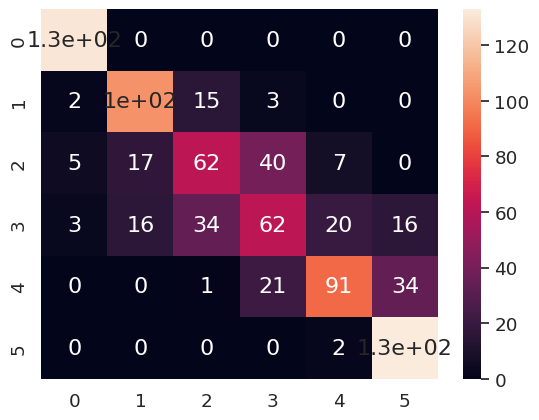

SMOTE Data 
               precision    recall  f1-score   support

           3       0.93      1.00      0.96       131
           4       0.76      0.84      0.80       123
           5       0.55      0.47      0.51       131
           6       0.49      0.41      0.45       151
           7       0.76      0.62      0.68       147
           8       0.73      0.99      0.84       135

    accuracy                           0.71       818
   macro avg       0.70      0.72      0.71       818
weighted avg       0.70      0.71      0.70       818



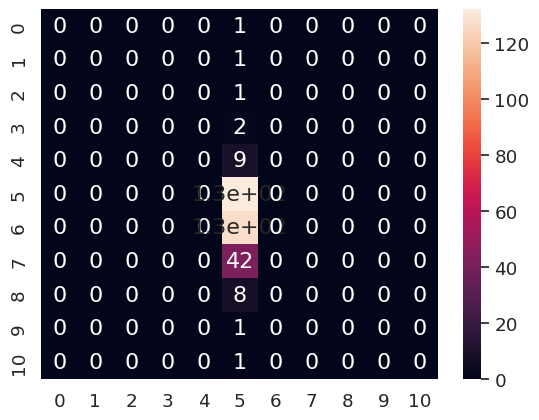

Imputed Data 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.41      1.00      0.58       132
           6       0.00      0.00      0.00       127
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.41       325
   macro avg       0.04      0.09      0.05       325
weighted avg       0.16      0.41      0.23       325



In [79]:
wineSVM = SVC()
clas_report(X_train, y_train, X_test, y_test, wineSVM, 'Regular Data')
clas_report(X_over_train, y_over_train, X_over_test, y_over_test, wineSVM, 'Oversampled Data')
clas_report(X_under_train, y_under_train, X_under_test, y_under_test, wineSVM, 'Undersampled Data')
clas_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineSVM, 'SMOTE Data')
clas_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineSVM, 'Imputed Data')

## 3. Artificial Neural Network

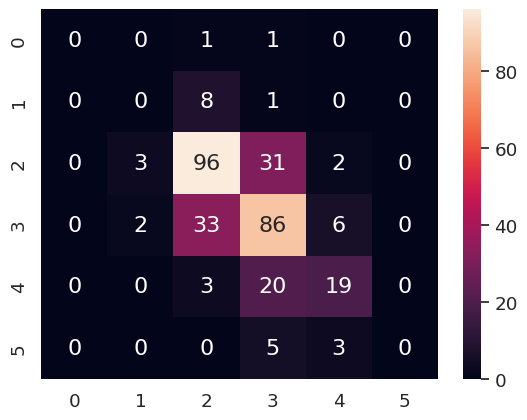

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.68      0.73      0.70       132
           6       0.60      0.68      0.63       127
           7       0.63      0.45      0.53        42
           8       0.00      0.00      0.00         8

    accuracy                           0.63       320
   macro avg       0.32      0.31      0.31       320
weighted avg       0.60      0.63      0.61       320



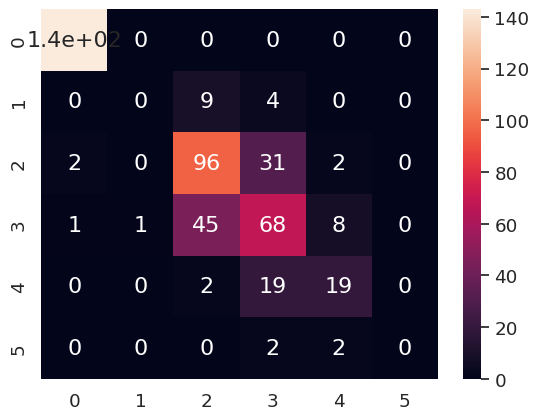

Oversampled Data 
               precision    recall  f1-score   support

           3       0.98      1.00      0.99       143
           4       0.00      0.00      0.00        13
           5       0.63      0.73      0.68       131
           6       0.55      0.55      0.55       123
           7       0.61      0.47      0.54        40
           8       0.00      0.00      0.00         4

    accuracy                           0.72       454
   macro avg       0.46      0.46      0.46       454
weighted avg       0.69      0.72      0.70       454



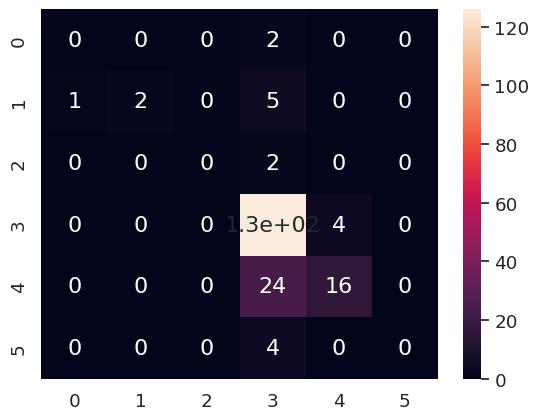

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.25      0.40         8
           5       0.00      0.00      0.00         2
           6       0.77      0.97      0.86       130
           7       0.80      0.40      0.53        40
           8       0.00      0.00      0.00         4

    accuracy                           0.77       186
   macro avg       0.43      0.27      0.30       186
weighted avg       0.76      0.77      0.73       186



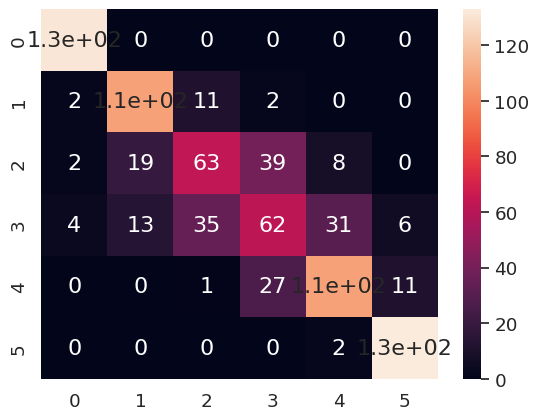

SMOTE Data 
               precision    recall  f1-score   support

           3       0.94      1.00      0.97       131
           4       0.77      0.88      0.82       123
           5       0.57      0.48      0.52       131
           6       0.48      0.41      0.44       151
           7       0.72      0.73      0.73       147
           8       0.89      0.99      0.93       135

    accuracy                           0.74       818
   macro avg       0.73      0.75      0.74       818
weighted avg       0.72      0.74      0.73       818



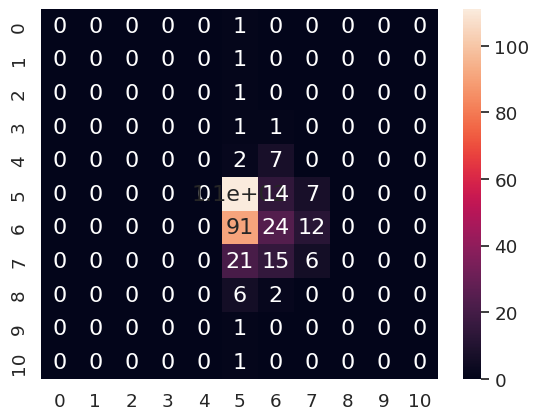

Imputed Data 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.47      0.84      0.60       132
           6       0.38      0.19      0.25       127
           7       0.24      0.14      0.18        42
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.43       325
   macro avg       0.10      0.11      0.09       325
weighted avg       0.37      0.43      0.37       325



In [80]:
wineMLP = MLPClassifier()
clas_report(X_train, y_train, X_test, y_test, wineMLP, 'Regular Data')
clas_report(X_over_train, y_over_train, X_over_test, y_over_test, wineMLP, 'Oversampled Data')
clas_report(X_under_train, y_under_train, X_under_test, y_under_test, wineMLP, 'Undersampled Data')
clas_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineMLP, 'SMOTE Data')
clas_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineMLP, 'Imputed Data')

## 4. Logistic Regression

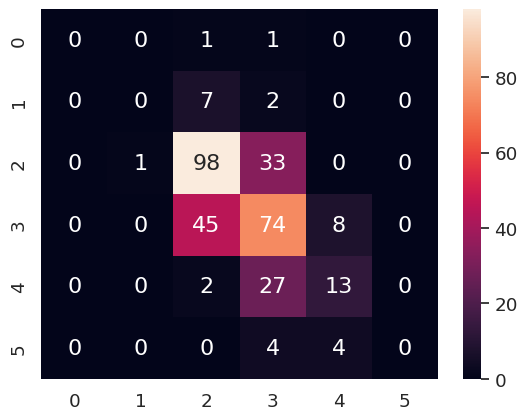

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.64      0.74      0.69       132
           6       0.52      0.58      0.55       127
           7       0.52      0.31      0.39        42
           8       0.00      0.00      0.00         8

    accuracy                           0.58       320
   macro avg       0.28      0.27      0.27       320
weighted avg       0.54      0.58      0.55       320



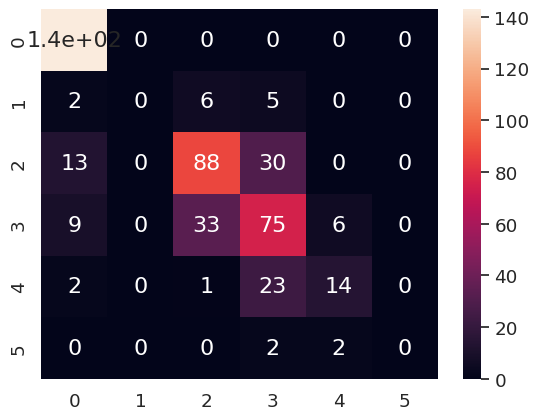

Oversampled Data 
               precision    recall  f1-score   support

           3       0.85      1.00      0.92       143
           4       0.00      0.00      0.00        13
           5       0.69      0.67      0.68       131
           6       0.56      0.61      0.58       123
           7       0.64      0.35      0.45        40
           8       0.00      0.00      0.00         4

    accuracy                           0.70       454
   macro avg       0.45      0.44      0.44       454
weighted avg       0.67      0.70      0.68       454



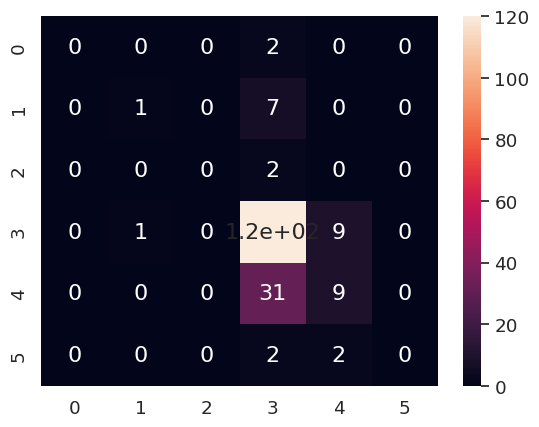

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.50      0.12      0.20         8
           5       0.00      0.00      0.00         2
           6       0.73      0.92      0.82       130
           7       0.45      0.23      0.30        40
           8       0.00      0.00      0.00         4

    accuracy                           0.70       186
   macro avg       0.28      0.21      0.22       186
weighted avg       0.63      0.70      0.64       186



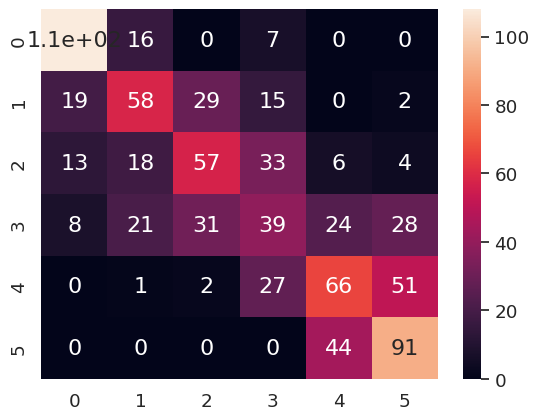

SMOTE Data 
               precision    recall  f1-score   support

           3       0.73      0.82      0.77       131
           4       0.51      0.47      0.49       123
           5       0.48      0.44      0.46       131
           6       0.32      0.26      0.29       151
           7       0.47      0.45      0.46       147
           8       0.52      0.67      0.59       135

    accuracy                           0.51       818
   macro avg       0.50      0.52      0.51       818
weighted avg       0.50      0.51      0.50       818



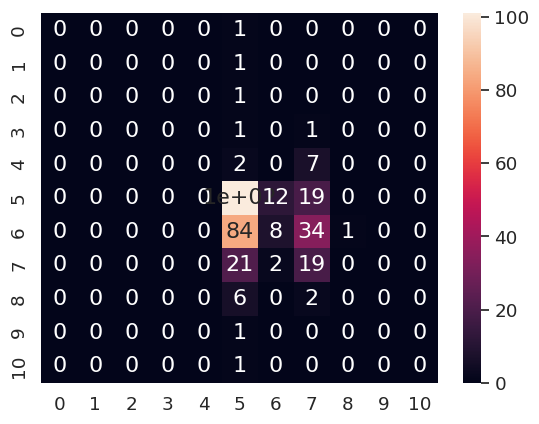

Imputed Data 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.46      0.77      0.57       132
           6       0.36      0.06      0.11       127
           7       0.23      0.45      0.31        42
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.39       325
   macro avg       0.10      0.12      0.09       325
weighted avg       0.36      0.39      0.31       325



In [81]:
wineLR = LogisticRegression()
clas_report(X_train, y_train, X_test, y_test, wineLR, 'Regular Data')
clas_report(X_over_train, y_over_train, X_over_test, y_over_test, wineLR, 'Oversampled Data')
clas_report(X_under_train, y_under_train, X_under_test, y_under_test, wineLR, 'Undersampled Data')
clas_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineLR, 'SMOTE Data')
clas_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineLR, 'Imputed Data')

# 4. Hyperparameter Tuning

## 1. Random Forest Classifier

In [82]:
def grid_search(X_train, y_train, model, param_grid, title):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    print(title, ": ", grid.best_params_)
    print("best score: ", grid.best_score_)

In [83]:
wineRFC = RandomForestClassifier(random_state=417)

param_grid_RFC = { 
    'n_estimators': [100, 200, 400, 500, 1000],
    'max_depth': [5,6,7,8],
}

grid_search(X_train, y_train, wineRFC, param_grid_RFC, 'Regular Data')
grid_search(X_over_train, y_over_train, wineRFC, param_grid_RFC, 'Oversampled Data')
grid_search(X_under_train, y_under_train, wineRFC, param_grid_RFC, 'Undersampled Data')
grid_search(X_smote_train, y_smote_train, wineRFC, param_grid_RFC, 'SMOTE Data')
grid_search(X_impute_train, y_impute_train, wineRFC, param_grid_RFC, 'Imputed Data')

## 2. Support Vector Machine

In [ ]:
wineSVM = SVC()
param_grid_svm = {
    'kernel': ['rbf','sigmoid','poly'], 
    'C': [1, 10, 100, 1000]
}

grid_search(X_train, y_train, wineSVM, param_grid_svm, 'Regular Data')
grid_search(X_over_train, y_over_train, wineSVM, param_grid_svm, 'Oversampled Data')
grid_search(X_under_train, y_under_train, wineSVM, param_grid_svm, 'Undersampled Data')
grid_search(X_smote_train, y_smote_train, wineSVM, param_grid_svm, 'SMOTE Data')
grid_search(X_impute_train, y_impute_train, wineSVM, param_grid_svm, 'Imputed Data')

## 3. Artificial Neural Network

In [ ]:
wineANN = MLPClassifier()
param_grid_ann = {
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 300, 400, 500],
}

grid_search(X_train, y_train, wineANN, param_grid_ann, 'Regular Data')
grid_search(X_over_train, y_over_train, wineANN, param_grid_ann, 'Oversampled Data')
grid_search(X_under_train, y_under_train, wineANN, param_grid_ann, 'Undersampled Data')
grid_search(X_smote_train, y_smote_train, wineANN, param_grid_ann, 'SMOTE Data')
grid_search(X_impute_train, y_impute_train, wineANN, param_grid_ann, 'Imputed Data')

## 4. Logistic Regression

In [ ]:
wineLR = LogisticRegression()
param_grid_lr = {
    'penalty' : ['l1', 'l2'],
    'solver':['lbfgs', 'liblinear','saga']
}

grid_search(X_train, y_train, wineLR, param_grid_lr, 'Regular Data')
grid_search(X_over_train, y_over_train, wineLR, param_grid_lr, 'Oversampled Data')
grid_search(X_under_train, y_under_train, wineLR, param_grid_lr, 'Undersampled Data')
grid_search(X_smote_train, y_smote_train, wineLR, param_grid_lr, 'SMOTE Data')
grid_search(X_impute_train, y_impute_train, wineLR, param_grid_lr, 'Imputed Data')

# 5. Testing Final Models

In [65]:
def final_report(X_train, y_train, X_test, y_test, model, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(title, ": ", model.score(X_test, y_test))
    clas = classification_report(y_pred, y_test)
    print(clas)

## 1. Random Forest Classifier

In [ ]:
wineRF_regular_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=417)
wineRF_over_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=417)
wineRF_under_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=417)
wineRF_smote_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=417)
wineRF_impute_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=417)

final_report(X_train, y_train, X_test, y_test, wineRF_regular_final, 'Regular Data')
final_report(X_over_train, y_over_train, X_over_test, y_over_test, wineRF_over_final, 'Oversampled Data')
final_report(X_under_train, y_under_train, X_under_test, y_under_test, wineRF_under_final, 'Undersampled Data')
final_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineRF_smote_final, 'SMOTE Data')
final_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineRF_impute_final, 'Imputed Data')

## 2. Support Vector Machine

In [ ]:
wineSVM_regular_final = SVC(kernel = 'sigmoid', C = 1)
wineSVM_over_final = SVC(kernel = 'sigmoid', C = 1)
wineSVM_under_final = SVC(kernel = 'sigmoid', C = 1)
wineSVM_smote_final = SVC(kernel = 'sigmoid', C = 1)
wineSVM_impute_final = SVC(kernel = 'sigmoid', C = 1)

final_report(X_train, y_train, X_test, y_test, wineSVM_regular_final, 'Regular Data')
final_report(X_over_train, y_over_train, X_over_test, y_over_test, wineSVM_over_final, 'Oversampled Data')
final_report(X_under_train, y_under_train, X_under_test, y_under_test, wineSVM_under_final, 'Undersampled Data')
final_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineSVM_smote_final, 'SMOTE Data')
final_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineSVM_impute_final, 'Imputed Data')

## 3. Artificial Neural Network

In [ ]:
wineANN_regular_final = MLPClassifier(penalty='l1', solver= 'liblinear')
wineANN_over_final = MLPClassifier(penalty='l1', solver= 'liblinear')
wineANN_under_final = MLPClassifier(penalty='l1', solver= 'liblinear')
wineANN_smote_final = MLPClassifier(penalty='l1', solver= 'liblinear')
wineANN_impute_final = MLPClassifier(penalty='l1', solver= 'liblinear')

final_report(X_train, y_train, X_test, y_test, wineANN_regular_final, 'Regular Data')
final_report(X_over_train, y_over_train, X_over_test, y_over_test, wineANN_over_final, 'Oversampled Data')
final_report(X_under_train, y_under_train, X_under_test, y_under_test, wineANN_under_final, 'Undersampled Data')
final_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineANN_smote_final, 'SMOTE Data')
final_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineANN_impute_final, 'Imputed Data')

## 4. Logistic Regression

In [ ]:
wineLR_regular_final = LogisticRegression(penalty='l1', solver= 'liblinear')
wineLR_over_final = LogisticRegression(penalty='l1', solver= 'liblinear')
wineLR_under_final = LogisticRegression(penalty='l1', solver= 'liblinear')
wineLR_smote_final = LogisticRegression(penalty='l1', solver= 'liblinear')
wineLR_impute_final = LogisticRegression(penalty='l1', solver= 'liblinear')

final_report(X_train, y_train, X_test, y_test, wineLR_regular_final, 'Regular Data')
final_report(X_over_train, y_over_train, X_over_test, y_over_test, wineLR_over_final, 'Oversampled Data')
final_report(X_under_train, y_under_train, X_under_test, y_under_test, wineLR_under_final, 'Undersampled Data')
final_report(X_smote_train, y_smote_train, X_smote_test, y_smote_test, wineLR_smote_final, 'SMOTE Data')
final_report(X_impute_train, y_impute_train, X_impute_test, y_impute_test, wineLR_impute_final, 'Imputed Data')